#  Libraries & Functions

In [ ]:
!pip install coolprop

     |████████████████████████████████| 4.2 MB 26.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as cp
from IPython.display import display, Latex

In [ ]:
class Air:
  def __init__(self,T,P=None):
    self.T = T
    if P == None:
      self.P = 101325
    else:
      self.P = P 
  
  @property
  def Pr(self):
    return cp.PropsSI('Prandtl', 'T', self.T, 'P', self.P, 'Air')
  @property
  def c(self):
    return cp.PropsSI('CPMASS', 'T', self.T, 'P', self.P, 'Air')
  @property
  def k(self):
    return cp.PropsSI('CONDUCTIVITY', 'T', self.T, 'P', self.P, 'Air')
  @property
  def d(self):
    return cp.PropsSI('D', 'T', self.T, 'P', self.P, 'Air')
  @property
  def v(self):
    din_visc = cp.PropsSI('VISCOSITY', 'T', self.T, 'P', self.P, 'Air')
    return din_visc/self.d
  @property
  def a(self):
    return (self.k/(self.d*self.c))

  
air = Air(T=20+273)



In [ ]:
def get_h(Ts,Tamb,L):
  Tf = (Ts+Tamb)/2
  b = 1/Tf
  g = 9.81
  air = Air(T=Tf)
  k = air.k
  v = air.v
  Pr = air.Pr
  Ra = (g*b*(Ts-Tamb)*(L**3)*Pr)/(v**2)
  Nu = ((0.825 + ((0.387*(Ra**(1/6)))/((1+(0.492/Pr)**(9/16))**(8/27))))**2).real

  return (Nu*air.k)/L

def get_Ra(Ts,Tamb,L):
  Tf = (Ts+Tamb)/2
  b = 1/Tf
  g = 9.81
  air = Air(T=Tf)
  k = air.k
  v = air.v
  Pr = air.Pr
  return (g*b*(Ts-Tamb)*(L**3)*Pr)/(v**2)

def get_Nu(Ts,Tamb,L):
  Tf = (Ts+Tamb)/2
  b = 1/Tf
  g = 9.81
  air = Air(T=Tf)
  k = air.k
  v = air.v
  Pr = air.Pr
  Ra = (g*b*(Ts-Tamb)*(L**3)*Pr)/(v**2)
  return ((0.825 + ((0.387*(Ra**(1/6)))/((1+(0.492/Pr)**(9/16))**(8/27))))**2).real

get_h(90+273,30+273,0.6)

def eng(val, digits = 3):
  eng_val = val
  eng_pow = 0
  if val > 0:
    while eng_val > 10:
      eng_val = eng_val/10
      eng_pow += 1
  else:
    while eng_val < 1:
      eng_val = eng_val*10
      eng_pow -= 1

  return str(round(eng_val,digits)) + 'e' + str(eng_pow)





# Parameters

## Geometry of mold

In [ ]:
#@markdown Mold height ($mm$)
mold_h = 70 #@param {type:"number"}
#@markdown Mold width ($mm$)
mold_w = 810 #@param {type:"number"}
#@markdown Mold length ($mm$)
mold_l = 1100 #@param {type:"number"}
#@markdown Heating part height ($mm$)
heating_part_h = 130 #@param {type:"number"}

Height = mold_h/1000
a = mold_w/1000
b = mold_l/1000
c = heating_part_h/1000

area_mold_sides = 2*Height*a + 2*Height*b
area_heating_sides = 2*c*a + 2*c*b
area_horizontal = a*b

##  Thermal parameters

In [ ]:
#@markdown Mold Temperature ($ºC$)
temp_mold = 160 #@param {type:"number"}

#@markdown Ambient Temperature ($ºC$)
temp_amb = 20 #@param {type:"number"}

#@markdown Emissivity Mold
emis_mold = 0.5 #@param {type:"number"}

#@markdown Emissivity Insulation
emis_insul = 0.1 #@param {type:"number"}

#@markdown Thermal conductivity insulation ($\frac{W}{mK}$)
k = 0.03 #@param {type:"number"}

#@markdown Insulation thickness ($mm$)
thickness =  100#@param {type:"number"}

T0 = temp_mold + 273
Tamb = temp_amb + 273
L = Height
t = thickness/1000

# Calculations

## Heat loss without insulation

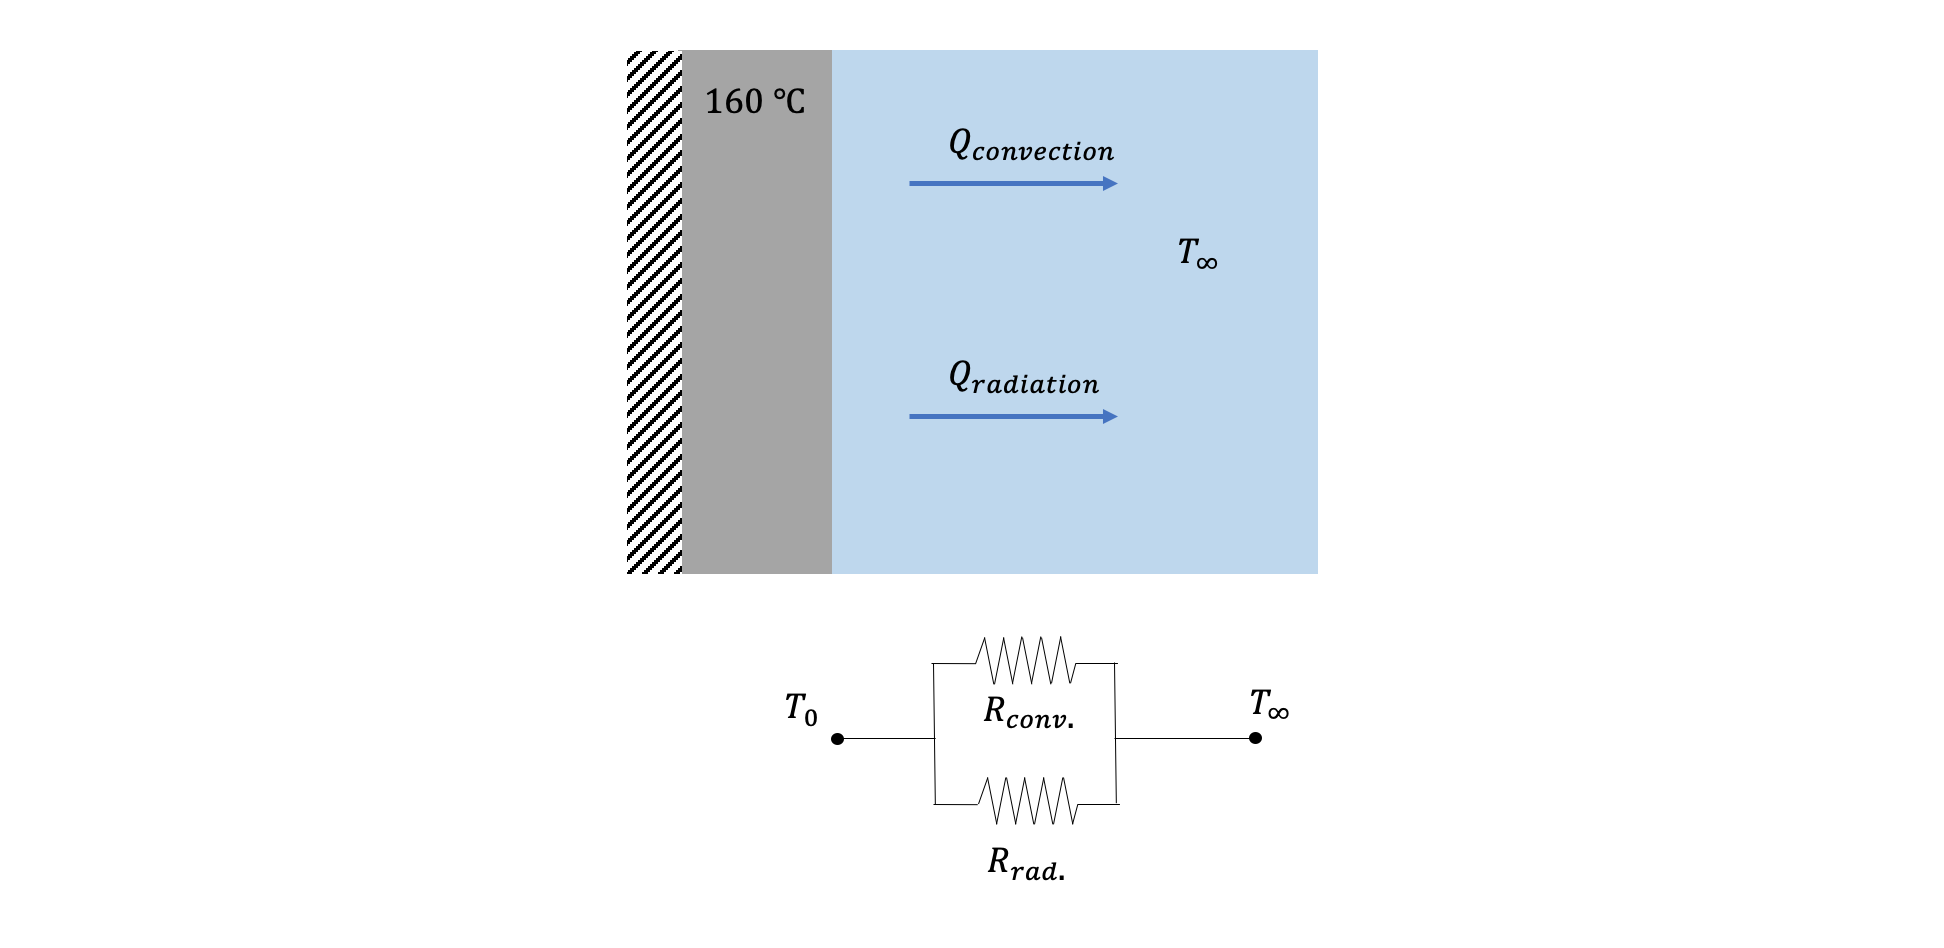

### Upper and Lower surfaces

In [ ]:
air = Air(T=(T0+Tamb)/2)
Lc_hor = (area_horizontal)/(2*a + 2*b)
Ra = get_Ra(T0,Tamb,Lc_hor)

Nu_sup = 0.27*(Ra**(1/4))
Nu_inf = 0.1*(Ra**(1/3))

h_sup = ((Nu_sup*air.k)/Lc_hor)
h_inf = ((Nu_inf*air.k)/Lc_hor)

Q_sup = (area_horizontal)*h_sup*(T0 - Tamb)
Q_inf = (area_horizontal)*h_inf*(T0 - Tamb)

print('Ra:\t\t\t',eng(Ra))
print('Heat loss Sup. (W):\t',round(Q_sup,2))
print('Heat loss Inf. (W):\t',round(Q_inf,2))

Ra:			 6.916e7
Heat loss Sup. (W):	 407.09
Heat loss Inf. (W):	 678.66


### Sides surfaces

In [ ]:
h0_conv = get_h(T0,Tamb,L)
h0_rad = 5.67e-8 * emis_mold * (T0 + Tamb)*(T0**2 + Tamb**2)
R0  = 1/(h0_conv + h0_rad)

q_sides = (T0 - Tamb)/R0

### Steps

In [ ]:
dt0 = 250
dt1 = 4
dt2 = 30
dt3 = 60

#Step 0
Q0 = 2*q_sides*(area_heating_sides+area_mold_sides) 
E0 = Q0*dt0
#Step 1
Q1 = 2*q_sides*(area_heating_sides+area_mold_sides) + Q_inf + Q_sup
E1 = Q1*dt1
#Step 2
Q2 = 2*q_sides*(area_heating_sides+area_mold_sides) + 2*Q_inf + 2*Q_sup
E2 = Q2*dt2
#Step 3
Q3= 2*q_sides*(area_heating_sides+area_mold_sides) + Q_inf + Q_sup
E3 = Q3*dt3

#Total
E_total = E0 + E1 + E2 + E3

print("Step 0 | Energy loss (kJ):", E0/1000)
print("Step 1 | Energy loss (kJ):", E1/1000)
print("Step 2 | Energy loss (kJ):", E2/1000)
print("Step 3 | Energy loss (kJ):", E3/1000)
print("Total  | Energy loss (kJ):", E_total/1000)

Step 0 | Energy loss (kJ): 762.7828758710992
Step 1 | Energy loss (kJ): 16.547517437846547
Step 2 | Energy loss (kJ): 156.67881646316638
Step 3 | Energy loss (kJ): 248.21276156769824
Total  | Energy loss (kJ): 1184.2219713398104


## Heat loss with insulation

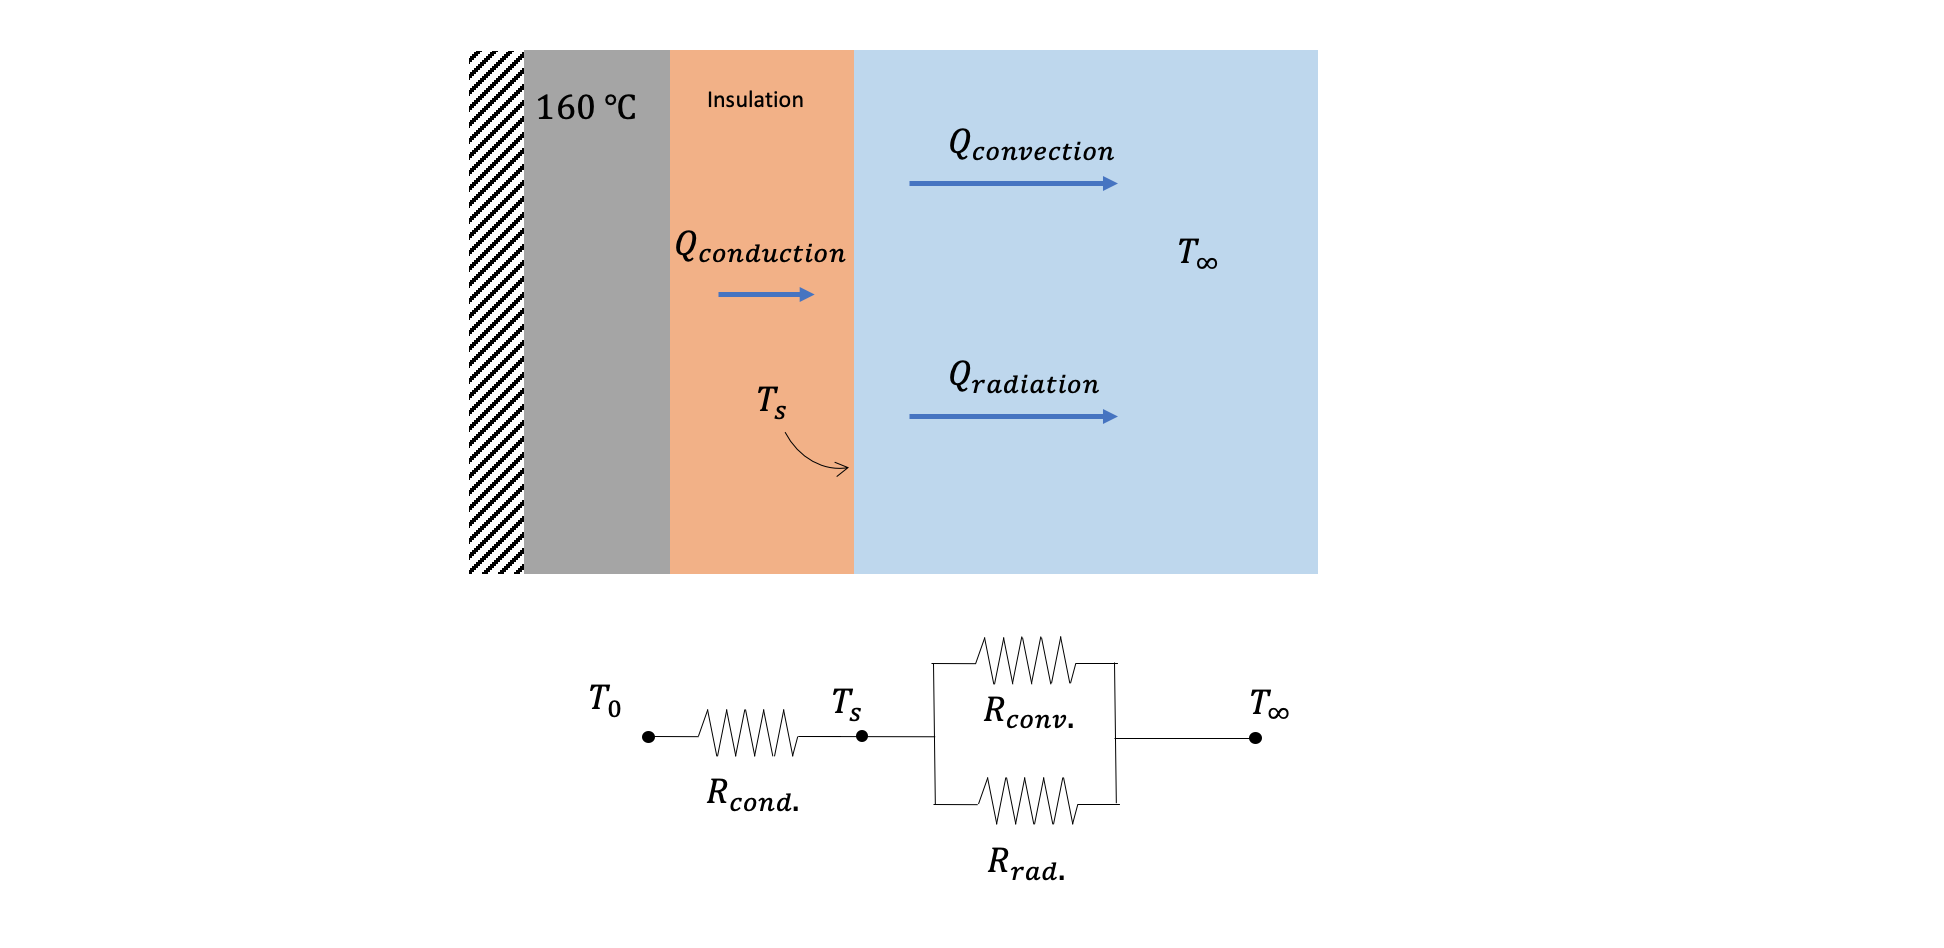

The heat loss due to radiation and convection depends on the temperature at the surface ($T_s$). At the same time the temperature at the surface depends on how much heat is lost due to convection and radiation, threfore the solution is an implicit equation and it must be solved by iterating. In this case 5 iterations are proved to be more than enough. To start the iterating proccess an arbitrary surface temperature of $T_s = 300 K$ is choseen.

$ $

$R_{convection} = \frac{1}{h_{convection}(T_s)} \hspace{20mm}$    $R_{radiation} = \frac{1}{h_{radiation}(T_s)}$ $\hspace{20mm} R_{conduction} = \frac{t}{k} \hspace{20mm}$
$R_{combined} = \left(\frac{1}{R_{conv}}+\frac{1}{R_{rad}}\right)^{-1}$

$ $

$\dot{q} = \dot{q}_{conduction} = \dot{q}_{combined} $
$\implies \frac{T_0 - T_{\infty}}{R_{cond} + R_{comb}} = \frac{T_0 - T_{s}}{R_{cond}} = \frac{T_s - T_{\infty}}{R_{comb}}$

$ $

$h_{radiation} = 5.67 \cdot 10^{-8} \cdot \epsilon \cdot (T_s + T_{\infty})(T_s^2 + T_{\infty}^2) $

$ $

$h_{convection} = Nu(T_s) \cdot \frac{ k_{air}}{L}$

$ $

$Nu$ is obtained from the equations of chapter *9-3* of the book: *Heat and mass transfer fundamentals and applications by Yunus A.*

In [ ]:
Ts = 300
for n in range(5):
  h_conv = get_h(Ts,Tamb,L)
  h_rad = 5.67e-8 * emis_insul * (Ts + Tamb)*(Ts**2 + Tamb**2)
  R_comb = 1/(h_conv + h_rad)
  R_cond = t/k
  
  q = (T0-Tamb)/(R_cond + R_comb)

  Ts = T0 - (q*(t/k))

q_ins_sides = (Ts - Tamb)*(h_conv + h_rad)

#Step 0
Q0_ins = 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides
E0_ins = Q0_ins*dt0
#Step 1
Q1_ins = 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides + Q_inf + Q_sup
E1_ins = Q1_ins*dt1
#Step 2
Q2_ins = 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides + 2*Q_inf + 2*Q_sup
E2_ins = Q2_ins*dt2
#Step 3
Q3_ins= 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides + Q_inf + Q_sup
E3_ins = Q3_ins*dt3

#Total
E_total_ins = E0_ins + E1_ins + E2_ins + E3_ins

print("Step 0 | Energy loss (kJ):", E0_ins/1000)
print("Step 1 | Energy loss (kJ):", E1_ins/1000)
print("Step 2 | Energy loss (kJ):", E2_ins/1000)
print("Step 3 | Energy loss (kJ):", E3_ins/1000)
print("Total  | Energy loss (kJ):", E_total_ins/1000)

Step 0 | Energy loss (kJ): 501.10532400161566
Step 1 | Energy loss (kJ): 12.360676607934813
Step 2 | Energy loss (kJ): 125.27751023882834
Step 3 | Energy loss (kJ): 185.41014911902218
Total  | Energy loss (kJ): 824.1536599674009


# Results

In [ ]:
print('T surface insulation (ºC):','\t', round(Ts-273,3))
print('E without insulation (kJ):','\t', round(E_total/1000,3))
print('E with insulation (kJ):','\t', round(E_total_ins/1000,3))
print('Energy loss reduction (%):', '\t', round(100*(1-(E_total_ins/E_total)),3))

T surface insulation (ºC): 	 27.952
E without insulation (kJ): 	 1184.222
E with insulation (kJ): 	 824.154
Energy loss reduction (%): 	 30.405


## Get required thickness

In [ ]:
r_target  = 0.3 #%
t = 1/1000
t_step = 1/1000
r = 0

while r < r_target:

  Ts = 300
  for n in range(5):

    h_conv = get_h(Ts,Tamb,L)
    h_rad = 5.67e-8 * emis_insul * (Ts + Tamb)*(Ts**2 + Tamb**2)
    R_comb = 1/(h_conv + h_rad)
    R_cond = t/k
    
    q = (T0-Tamb)/(R_cond + R_comb)

    Ts = T0 - (q*(t/k))

  q_ins_sides = (Ts - Tamb)*(h_conv + h_rad)

  #Step 0
  Q0_ins = 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides
  E0_ins = Q0_ins*dt0
  #Step 1
  Q1_ins = 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides + Q_inf + Q_sup
  E1_ins = Q1_ins*dt1
  #Step 2
  Q2_ins = 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides + 2*Q_inf + 2*Q_sup
  E2_ins = Q2_ins*dt2
  #Step 3
  Q3_ins= 2*q_sides*area_heating_sides + 2*q_ins_sides*area_mold_sides + Q_inf + Q_sup
  E3_ins = Q3_ins*dt3

  #Total
  E_total_ins = E0_ins + E1_ins + E2_ins + E3_ins

  r = 1-(E_total_ins/E_total)

  t += t_step

print('Energy loss reduction (%):\t', round(100*(r),1))
print("Minimum thickness (mm):\t\t", round(t*1000,2))

Energy loss reduction (%):	 30.0
Minimum thickness (mm):		 60.0


##  Export Results

In [ ]:
doc = open("project2_results.csv","w")

doc.write("Energy loss at each step\n")
doc.write("Insulation;Step;Time (s);Energy loss (kJ)\n")
doc.write("NO;0;"+str(dt0)+";"+str(E0/1000)+"\n")
doc.write("NO;1;"+str(dt1)+";"+str(E1/1000)+"\n")
doc.write("NO;2;"+str(dt2)+";"+str(E2/1000)+"\n")
doc.write("NO;3;"+str(dt3)+";"+str(E3/1000)+"\n")
doc.write("NO;Total;"+str(dt0 + dt1 + dt2 + dt3)+";"+str(E_total/1000)+"\n")
doc.write("YES;0;"+str(dt0)+";"+str(E0_ins/1000)+"\n")
doc.write("YES;1;"+str(dt1)+";"+str(E1_ins/1000)+"\n")
doc.write("YES;2;"+str(dt2)+";"+str(E2_ins/1000)+"\n")
doc.write("YES;3;"+str(dt3)+";"+str(E3_ins/1000)+"\n")
doc.write("YES;Total;"+str(dt0 + dt1 + dt2 + dt3)+";"+str(E_total_ins/1000)+"\n")

doc.write("\n\n")
doc.write("Minimum thickness(mm);" + str(round(t*1000,2)))
doc.write("\nEnergy loss reduction(%);" + str(round(100*(r),1)))

doc.close()